f_ZEA: 999.9999999999999
target crossover frequency: 10000.0
C_SS: 8.230452674897118e-09
R_T: 3110.328638497653
R_S: 0.07585638810931278
R_FB2, R_FB1: 20000.0, 11654.676258992808
C_RAMP: 6.778159090909093e-11
R_COMP, C_COMP, C_HF: 300000.0, 5.305164769729845e-10, 5.305164769729845e-12
11606.01144517523 -292.15040607529903
I_PEAK: 0.8018103727714753
I_PP: 0.2
L recommandation: 2.079e-05


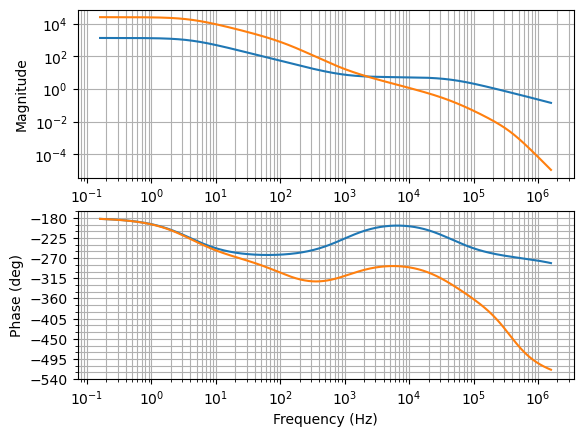

In [47]:
import control as co
import numpy as np

V_IN, V_OUT = 60, 3.3
D = V_OUT / V_IN
f_SW = 750e+3
T = 1 / f_SW
V_IN_MIN, V_IN_MAX = 6, 60

L, C_OUT, ESR, R_LOAD = 10e-6, 47 * 2e-6, 0.2e-3, 330

V_ref = 1.215
K_FB = V_ref / V_OUT
R_FB2 = 20e+3
R_FB1 = K_FB * R_FB2 / (1 - K_FB)

g_m = 5e-6
i_R = g_m * (V_IN - V_OUT) + 25e-6
V_CS_TH = 0.11
I_OUT = 1
R_S = V_CS_TH / (I_OUT - V_OUT * T / (2 * L) * (1 - V_OUT / V_IN_MIN) + V_OUT * T / L * (1 + (5 - V_OUT) / V_IN_MIN) / (1 + (5 - V_OUT) / V_IN_MAX))
# R_S = 0.01
A = 10
C_RAMP = g_m * L / (A * R_S) * (1 + (5 - V_OUT) / V_IN_MAX)
V_CC = 7.4
I_OS = 25e-6

# f_p0, f_z1, f_p1 = 2.0e+3, 2.2e+3, 220e+3
# R_COMP = f_p0 * R_FB2 / f_z1
# C_COMP = 1 / (2 * np.pi * R_FB2 * f_p0)
# C_HF = f_z1 / (2 * np.pi * R_FB2 * f_p0 * f_p1)

R_COMP = 300e+3
f_ZEA = 1e+3
C_COMP = 1 / (2 * np.pi * f_ZEA * R_COMP)
f_HF = 100e+3
C_HF = 1 / (2 * np.pi * f_HF * R_COMP)

K_SL = g_m * T / C_RAMP
V_SL = I_OS * T / C_RAMP
K_m = 1 / ((D - 0.5) * A * R_S * T / L + (1 - 2 * D) * K_SL + V_SL / V_IN)
w_Z = 1 / (C_OUT * ESR)
w_P = 1 / C_OUT * (1 / R_LOAD + 1 / (K_m * A * R_S))
w_n = np.pi / T
S_e, S_n = ((V_IN - V_OUT) * K_SL + V_SL) / T, V_IN * A * R_S / L
m_C = S_e / S_n
Q = 1 / (np.pi * (m_C - 0.5))

w_ZEA = 1 / (C_COMP * R_COMP)
w_O = 1 / ((C_HF + C_COMP) * R_FB2)
w_HF = (C_HF + C_COMP) / (C_HF * C_COMP * R_COMP)
f_BW = 3000000
w_BW = 2 * np.pi * f_BW
A_OL = 10000

G_comp_to_out = R_LOAD / (A * R_S) / (1 + R_LOAD / (K_m * A * R_S)) * co.tf([1 / w_Z, 1], [1]) / (co.tf([1 / w_P, 1], [1]) * co.tf([1 / (w_n ** 2), 1 / (w_n * Q), 1], [1]))

G_EA = co.tf([1 / w_ZEA, 1], [1 / (w_O * w_HF), 1 / w_O, 0])
G_out_to_comp = -K_FB * G_EA / (1 + co.tf([1 / w_BW, 1 / A_OL], [1]) * (1 + G_EA / K_FB))

G_loop = G_comp_to_out * G_out_to_comp

# mag, phase, omega = co.bode(G_comp_to_out, np.logspace(0, 7, 1000), Hz=True)
mag, phase, omega = co.bode(G_out_to_comp, np.logspace(0, 7, 1000), Hz=True)
mag, phase, omega = co.bode(G_loop, np.logspace(0, 7, 1000), Hz=True)

t_SS = 1e-3
C_SS = t_SS * 10e-6 / 1.215

print('f_ZEA: {}'.format(w_ZEA / (2 * np.pi)))
print('target crossover frequency: {}'.format(np.sqrt(f_ZEA * f_HF)))
print('C_SS: {}'.format(C_SS))
print('R_T: {}'.format((T - 450e-9) / 284e-12))
print('R_S: {}'.format(R_S))
print('R_FB2, R_FB1: {}, {}'.format(R_FB2, R_FB1))
print('C_RAMP: {}'.format(C_RAMP))
print('R_COMP, C_COMP, C_HF: {}, {}, {}'.format(R_COMP, C_COMP, C_HF))

def get_crossover_state (mag, phase, omega):
  for i in range(0, len(mag) - 1):
    if not ((mag[i] >= 1 and mag[i + 1] >= 1) or (mag[i] <= 1 and mag[i + 1] <= 1)):
      return [omega[i], phase[i]]
  return [-1, -1]

crossover_state = get_crossover_state(mag, phase, omega)
print(crossover_state[0] / (2 * np.pi), crossover_state[1] * 180 / np.pi)
print('I_PEAK: {}'.format((1.1 - 25e-6 * T / C_RAMP) / (A * R_S)))
I_PP = 1 * 0.2
print('I_PP: {}'.format(I_PP))
print('L recommandation: {}'.format(V_OUT / (I_PP * f_SW) * (1 - V_OUT / V_IN_MAX)))


crossover frequency: 25000.0
C_SS: 8.230452674897118e-09
R_T: 3160.946812953191
R_S: 0.007
R_FB2, R_FB1: 18700.0, 10900.0
C_RAMP: 8.2e-11
R_COMP, C_COMP, C_HF: 78700.0, 1.5e-10, 5.1e-12
69576.21070403921 -294.32308098491376


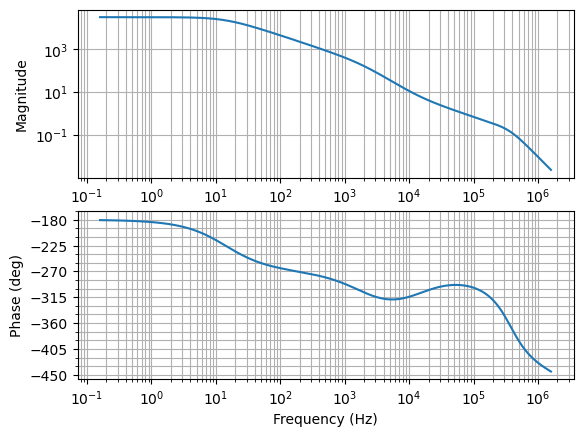

In [186]:
import control as co
import numpy as np
import matplotlib.pyplot as plt

V_IN, V_OUT = 36, 3.3
D = V_OUT / V_IN
f_SW = 742e+3
T = 1 / f_SW

L, C_OUT, ESR, R_LOAD = 1e-6, 47e-6, 20e-3, 50

V_ref = 1.215
K_FB = V_ref / V_OUT
R_FB2 = 18.7e+3
R_FB1 = 10.9e+3

g_m = 5e-6
i_R = g_m * (V_IN - V_OUT) + 25e-6
V_CS_TH = 0.11
R_S = 0.007
A = 10
C_RAMP = 82e-12
V_CC = 7.4
I_OS = 25e-6

R_COMP = 78.7e+3
C_COMP = 150e-12
C_HF = 5.1e-12

K_SL = g_m * T / C_RAMP
V_SL = I_OS * T / C_RAMP
K_m = 1 / ((D - 0.5) * A * R_S * T / L + (1 - 2 * D) * K_SL + V_SL / V_IN)
w_Z = 1 / (C_OUT * ESR)
w_P = 1 / C_OUT * (1 / R_LOAD + 1 / (K_m * A * R_S))
w_n = np.pi / T
S_e, S_n = ((V_IN - V_OUT) * K_SL + V_SL) / T, V_IN * A * R_S / L
m_C = S_e / S_n
Q = 1 / (np.pi * (m_C - 0.5))

w_ZEA = 1 / (C_COMP * R_COMP)
w_O = 1 / ((C_HF + C_COMP) * R_FB2)
w_HF = (C_HF + C_COMP) / (C_HF * C_COMP * R_COMP)
f_BW = 3000000
w_BW = 2 * np.pi * f_BW
A_OL = 10000

G_comp_to_out = R_LOAD / (A * R_S) / (1 + R_LOAD / (K_m * A * R_S)) * co.tf([1 / w_Z, 1], [1]) / (co.tf([1 / w_P, 1], [1]) * co.tf([1 / (w_n ** 2), 1 / (w_n * Q), 1], [1]))

G_EA = co.tf([1 / w_ZEA, 1], [1 / (w_O * w_HF), 1 / w_O, 0])
G_out_to_comp = -K_FB * G_EA / (1 + co.tf([1 / w_BW, 1 / A_OL], [1]) * (1 + G_EA / K_FB))

G_loop = G_comp_to_out * G_out_to_comp

# mag, phase, omega = co.bode(G_comp_to_out, np.logspace(0, 7, 1000), Hz=True)
# mag, phase, omega = co.bode(G_out_to_comp, np.logspace(0, 7, 1000), Hz=True)
mag, phase, omega = co.bode(G_loop, np.logspace(0, 7, 1000), Hz=True)

print('crossover frequency: {}'.format(np.sqrt(f_z1 * f_p1)))
print('C_SS: {}'.format(C_SS))
print('R_T: {}'.format((T - 450e-9) / 284e-12))
print('R_S: {}'.format(R_S))
print('R_FB2, R_FB1: {}, {}'.format(R_FB2, R_FB1))
print('C_RAMP: {}'.format(C_RAMP))
print('R_COMP, C_COMP, C_HF: {}, {}, {}'.format(R_COMP, C_COMP, C_HF))

def get_crossover_state (mag, phase, omega):
  for i in range(0, len(mag) - 1):
    if not ((mag[i] >= 1 and mag[i + 1] >= 1) or (mag[i] <= 1 and mag[i + 1] <= 1)):
      return [omega[i], phase[i]]
  return [-1, -1]

crossover_state = get_crossover_state(mag, phase, omega)
print(crossover_state[0] / (2 * np.pi), crossover_state[1] * 180 / np.pi)
